In [1]:
import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib as plt

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 70)

import sys
sys.path.append('../')  # to import helpers
from scripts._helpers import _sets_path_to_root
_sets_path_to_root("pypsa-africa")

This is the repository path:  /home/max/OneDrive/PHD-Flexibility/07_pypsa-africa/0github/pypsa-africa/pypsa-africa
Had to go 1 folder(s) up.


In [2]:
network_path = os.getcwd() + "/networks/elec.nc"
n = pypsa.Network(network_path)
n

Index(['454552252-1', '192259642-1', '664681179-1', '26432885-1',
       '179675615-1', '179048702-1', '557389552-2', '584908166-1',
       '179048704-1', '905071172-1',
       ...
       '701923227-1', '179675607-2', '559111770-1', '89084615-1',
       '700719158-2', '454513841-1', '866932477-1', '664681170-1',
       '115322213-1', '452716570-1'],
      dtype='object', name='name', length=123)
Index(['454552252-1', '192259642-1', '664681179-1', '26432885-1',
       '179675615-1', '179048702-1', '557389552-2', '584908166-1',
       '179048704-1', '905071172-1',
       ...
       '701923227-1', '179675607-2', '559111770-1', '89084615-1',
       '700719158-2', '454513841-1', '866932477-1', '664681170-1',
       '115322213-1', '452716570-1'],
      dtype='object', name='name', length=123)
INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines


Network PyPSA-Eur

In [3]:
import xarray as xr

path = os.path.realpath("networks")+"/elec.nc"
network_data = xr.open_dataset(path)

network_data

<xarray.Dataset>
Dimensions:                       (snapshots: 8760, investment_periods: 0, buses_i: 20400, generators_i: 1470, generators_t_p_max_pu_i: 1470, lines_i: 10323, carriers_i: 4)
Coordinates:
  * snapshots                     (snapshots) int64 0 1 2 3 ... 8757 8758 8759
  * investment_periods            (investment_periods) float64 
  * buses_i                       (buses_i) object '0' '1' ... '20644' '20645'
  * generators_i                  (generators_i) object '4358 onwind' ... '15...
  * generators_t_p_max_pu_i       (generators_t_p_max_pu_i) object '14682 onw...
  * lines_i                       (lines_i) object '381266480-1' ... '6967262...
  * carriers_i                    (carriers_i) object 'onwind' ... 'solar'
Data variables: (12/49)
    snapshots_snapshot            (snapshots) datetime64[ns] ...
    snapshots_objective           (snapshots) float64 ...
    snapshots_stores              (snapshots) float64 ...
    snapshots_generators          (snapshots) float64 ...
    investment_periods_objective  (investment_periods) float64 ...
    investment_periods_years      (investment_periods) float64 ...
    ...                            ...
    lines_bus_1_coors             (lines_i) float64 ...
    lines_type                    (lines_i) object ...
    lines_s_max_pu                (lines_i) float64 ...
    lines_s_nom                   (lines_i) float64 ...
    carriers_color                (carriers_i) object ...
    carriers_nice_name            (carriers_i) object ...
Attributes:
    network_name:           PyPSA-Eur
    network_pypsa_version:  0.18.0
    network_srid:           4326

In [4]:
n.buses.head(2)

,v_nom,symbol,under_construction,tag_substation,tag_area,lon,lat,country,substation_lv,x,y,substation_off,type,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
name,,,,,,,,,,,,,,,,,,,,
0,220.0,False,False,False,False,-0.190303,35.768513,DZ,True,-0.190303,35.768513,False,,AC,None,1.0,0.0,inf,PQ,
1,220.0,False,False,False,False,-0.395014,35.534567,DZ,True,-0.395014,35.534567,False,,AC,None,1.0,0.0,inf,PQ,


In [5]:
n.lines.head(2)

,bus0,bus1,v_nom,num_parallel,length,underground,under_construction,tag_type,tag_frequency,country,geometry,bounds,bus0_lon,bus0_lat,bus1_lon,bus1_lat,bus_0_coors,bus_1_coors,type,s_max_pu,s_nom,x,r,g,b,s_nom_extendable,s_nom_min,s_nom_max,capital_cost,build_year,lifetime,carrier,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
381266480-1,0,10323,220.0,1.0,46.739566,False,False,line,50,DZ,"LINESTRING (-0.1903026 35.76851289999971, -0.1861734 35.7674756999...","MULTIPOINT (-0.1903026 35.76851289999971, 0.1378516 35.87824859999...",-0.190303,35.768513,0.137852,35.878249,NaN,NaN,Al/St 240/40 2-bundle 220.0,0.7,491.556019,0.0,0.0,0.0,0.0,False,0.0,inf,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
381141189-1,1,10324,220.0,2.0,3.115450,False,False,line,50,DZ,"LINESTRING (-0.395014 35.5345674999999, -0.3943208 35.533282099999...","MULTIPOINT (-0.395014 35.5345674999999, -0.3749039 35.5425093)",-0.395014,35.534567,-0.374904,35.542509,NaN,NaN,Al/St 240/40 2-bundle 220.0,0.7,983.112038,0.0,0.0,0.0,0.0,False,0.0,inf,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
n.generators.groupby("carrier").p_nom_max.sum() / 1e3

carrier
onwind    1535.943296
solar     1535.943296
Name: p_nom_max, dtype: float64

In [7]:
# Maximal installable capacity at bus "14682 onwind"
n.generators.p_nom_max.loc["14682 onwind"] / 1e3

0.08379009618970745

### Maximal installable capacity at bus "14682 onwind"

<AxesSubplot:xlabel='snapshot'>

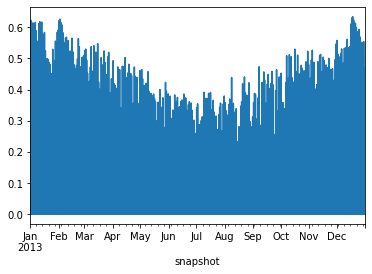

In [8]:
n.generators_t.p_max_pu.iloc[:,0].plot()

### Timeseries at bus "14682 onwind"

In [9]:
n.generators_t.p_max_pu.loc[:, "14682 onwind"]

snapshot
2013-01-01 00:00:00    0.0
2013-01-01 01:00:00    0.0
2013-01-01 02:00:00    0.0
2013-01-01 03:00:00    0.0
2013-01-01 04:00:00    0.0
                      ... 
2013-12-31 19:00:00    0.0
2013-12-31 20:00:00    0.0
2013-12-31 21:00:00    0.0
2013-12-31 22:00:00    0.0
2013-12-31 23:00:00    0.0
Name: 14682 onwind, Length: 8760, dtype: float64